<h1>Training from Scratch with ResNet18</h1>

* Features: 15-second mel spectrograms, augmented with pitch shift and pink noise
* Architecture: ResNet18 (modified for our inputs)
* Inputs: 256 x 128 greyscale mel spectrograms with db measures
* Model: Tuning from scratch
* Loss function: Soft Labeling Loss
* Target: ~250 musicmap genres

In [1]:
# Run this command if having trouble with import statements
# %pip install scikit-learn seaborn beautifulsoup4 pyvis

In [1]:
# Imports
import os

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import one_hot
from torch import nn, optim
from torch.optim.swa_utils import AveragedModel
from torch.amp import GradScaler
from torch.utils.data import DataLoader

import torchvision
import torchvision.models as models
from torchvision import transforms
from torchvision import transforms, datasets
import torchvision.transforms.functional as Fvision

import numpy as np

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import networkx as nx
from bs4 import BeautifulSoup
from collections import defaultdict
from pyvis.network import Network
import json
from tabulate import tabulate
from collections import Counter

Set the working directory

In [3]:
working_directory = './Data'

<h1>Shortest Path Matrix</h1>

One of our evaluation metrics will be the average shortest path. To compute this, we'll need to generate a shortest path matrix from the musicmap graph.

Since this process involves a lot of code that we'll be reusing with various models, I've saved the code as a separate, importable file.

In [ ]:
from musicmap_graph_creator import create_musicmap_graph, compute_shortest_paths_between_classes_nx

musicmap_graph = create_musicmap_graph(
    primary_edge_weight = 1, 
    secondary_edge_weight = 2,
    backlash_edge_weight = 3,
    supergenre_edge_weight = 4,
    world_supergenre_weight = 1,
    world_cluster_weight = 1,
    util_genre_weight = 2,
    cluster_weight = 1
)

shortest_graph, class_names = compute_shortest_paths_between_classes_nx(
    class_dir="./Data/15_second_features_augmented/musicmap_processed_output_splits_train/mel_db_gray",  # path to folder with class folders
    graph=musicmap_graph,
    return_tensor=True
)

<h2>Computing Means and SDs</h2>

The current code is meant to be used with a pre-trained resnet model. However, once we start training a model with our own data, we'll need to compute means and standard deviations for each channel. The code below will let us do that

In [5]:
def remove_alpha_channel(image_tensor):
    if image_tensor.shape[0] == 4:  # If there is an alpha channel
        return image_tensor[:3, :, :]  # Keep only the first three channels (RGB)
    return image_tensor  # Return unchanged if no alpha channel

In [9]:
# Code to compute means and SDs from images

def compute_image_dataset_stats(image_dir, batch_size=128, num_workers=4):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Ensure 1 channel
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x[:3, :, :] if x.shape[0] == 4 else x)  # remove alpha if needed
    ])

    dataset = datasets.ImageFolder(image_dir, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True)

    n_images = 0
    mean = 0.0
    std = 0.0

    for batch, _ in loader:
        n = batch.size(0)
        mean += batch.mean(dim=[0, 2, 3]) * n
        std += batch.std(dim=[0, 2, 3]) * n
        n_images += n

    mean /= n_images
    std /= n_images

    return tuple(mean.tolist()), tuple(std.tolist())

# Usage
image_dir = os.path.join(working_directory, '15_second_features_augmented/musicmap_processed_output_splits_train/mel_db_gray/')
means, sds = compute_image_dataset_stats(image_dir)

print('means are:', means)
print('standard deviations are:', sds)

means are: (0.4645683467388153,)
standard deviations are: (0.17180700600147247,)


Stacking the images takes about 90 seconds; to avoid this, we'll also have an option to "manually" input the means and standard deviations that were computed previously using the code below

In [6]:
# We can manually input the mean and SD values from a previous computation:
means = [0.4645683467388153]
sds = [0.17180700600147247]

<h2>Setting Up a Transformer</h2>

We'll use the means and standard deviations computed above to normalize the images.

Using ImageFolder might default to loading images as RGB, even if they're just greyscale. So we'll force greyscale as part of the transform.

In [7]:
transform_resnet = transforms.Compose([
    transforms.ToTensor(), # Should always be the last step before feeding into a model
    #transforms.Lambda(lambda x: remove_alpha_channel(x)),
    transforms.Grayscale(num_output_channels=1),  # force grayscale
    transforms.Normalize(mean=means, std=sds)    # Normalize to imagenet mean and standard deviation
])

<h1>Loading the Data</h1>

We'll begin by defining our datasets. Note that ImageFolder automatically creates labels from the folder structure.

In [8]:
train_dataset = torchvision.datasets.ImageFolder(
    root=os.path.join(working_directory, '15_second_features_augmented/musicmap_processed_output_splits_train/mel_db_gray/'),
    transform=transform_resnet
)

val_dataset = torchvision.datasets.ImageFolder(
    root=os.path.join(working_directory, '15_second_features_augmented/musicmap_processed_output_splits_val/mel_db_gray/'),
    transform=transform_resnet
)

Next, we'll make dataloaders that define batch sizes and shuffle the data.

In [9]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,  # Adjust batch size as needed
    shuffle=True,
    num_workers=4,  # Adjust this to tweak multiprocessing
    pin_memory=True,
    prefetch_factor=2
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=10,  # Adjust batch size as needed
    shuffle=False, #Setting to false keeps evaluation stable across epochs
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2 
)

Now let's check to make sure the train dataset is working correctly.

First, we'll check the number of samples and classes in both the train and val datasets

In [10]:
print(f"Number of samples in train: {len(train_dataset)}")
print(f"Classes in train: {train_dataset.classes}")
print(f"Class to index mapping in train: {train_dataset.class_to_idx}")

print(f"Number of samples in val: {len(val_dataset)}")
print(f"Classes in val: {val_dataset.classes}")
print(f"Class to index mapping in val: {val_dataset.class_to_idx}")

Number of samples in train: 18702
Classes in train: ['alt01', 'alt02', 'alt03', 'alt04', 'alt05', 'alt06', 'alt07', 'alt08', 'alt09', 'blu01', 'blu02', 'blu03', 'blu04', 'blu05', 'blu06', 'blu07', 'blu08', 'blu09', 'blu10', 'blu11', 'blu12', 'brb01', 'brb02', 'brb03', 'brb04', 'brb05', 'brb06', 'brb07', 'brb08', 'brb09', 'brb10', 'brb11', 'class', 'con01', 'con02', 'con03', 'con04', 'con05', 'con06', 'con07', 'cou01', 'cou02', 'cou03', 'cou04', 'cou05', 'cou06', 'cou07', 'cou08', 'cou09', 'cou10', 'cou11', 'dnb01', 'dnb02', 'dnb03', 'dnb04', 'dnb05', 'dnb06', 'dnb07', 'dnb08', 'dnb09', 'dnb10', 'dtp01', 'dtp02', 'dtp03', 'dtp04', 'dtp05', 'dtp06', 'dtp07', 'dtp08', 'dtp09', 'dtp11', 'dtp12', 'dtp13', 'dtp14', 'folk', 'gld01', 'gld02', 'gld03', 'gld04', 'gld05', 'gld06', 'gld07', 'gld08', 'gos01', 'gos02', 'gos03', 'gos04', 'gos05', 'hcp01', 'hcp02', 'hcp03', 'hcp04', 'hcp05', 'hcp06', 'hcp07', 'hct01', 'hct02', 'hct03', 'hct04', 'hct05', 'hct06', 'hct07', 'hct08', 'hct09', 'hct10', 'ho

We can also check to see how balanced the distribution of labels is

In [11]:
from collections import Counter

# Count label occurrences
label_counts = Counter()
for _, label in train_dataset:
    label_counts[label] += 1

# Map label indices to class names
idx_to_class = train_dataset.classes  # List where index i gives class name i

# Print counts with class names
for idx, count in label_counts.items():
    class_name = idx_to_class[idx]
    print(f"{idx:3d} | {count:5d} | {class_name}")


  0 |   100 | alt01
  1 |    88 | alt02
  2 |   112 | alt03
  3 |   106 | alt04
  4 |   101 | alt05
  5 |    95 | alt06
  6 |   116 | alt07
  7 |   102 | alt08
  8 |   108 | alt09
  9 |    99 | blu01
 10 |    86 | blu02
 11 |    93 | blu03
 12 |    88 | blu04
 13 |    86 | blu05
 14 |   103 | blu06
 15 |    99 | blu07
 16 |    88 | blu08
 17 |   107 | blu09
 18 |    88 | blu10
 19 |    97 | blu11
 20 |    89 | blu12
 21 |   104 | brb01
 22 |   116 | brb02
 23 |    91 | brb03
 24 |    85 | brb04
 25 |   121 | brb05
 26 |   121 | brb06
 27 |   110 | brb07
 28 |    93 | brb08
 29 |   104 | brb09
 30 |    89 | brb10
 31 |    95 | brb11
 32 |   108 | class
 33 |   100 | con01
 34 |    99 | con02
 35 |    99 | con03
 36 |    91 | con04
 37 |   100 | con05
 38 |    98 | con06
 39 |    99 | con07
 40 |    86 | cou01
 41 |    82 | cou02
 42 |    79 | cou03
 43 |    88 | cou04
 44 |    83 | cou05
 45 |    79 | cou06
 46 |   106 | cou07
 47 |    83 | cou08
 48 |    84 | cou09
 49 |    98 | cou10


Next, let's inspect a few samples to make sure they are being loaded and transformed correctly

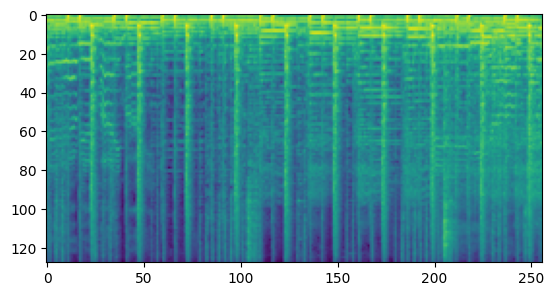

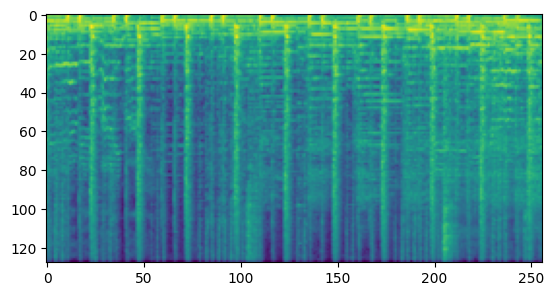

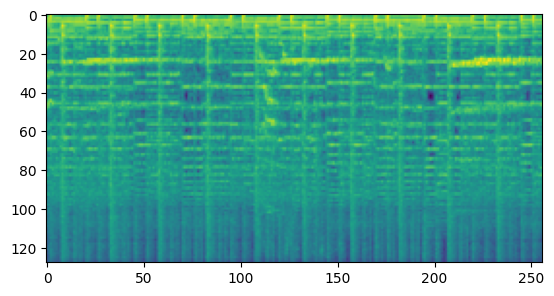

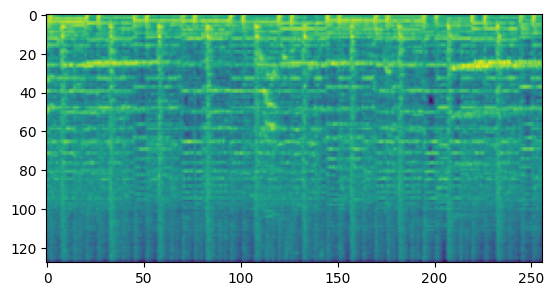

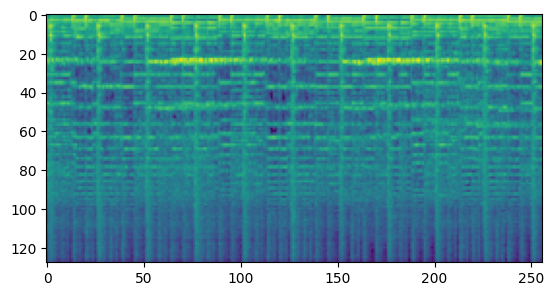

In [13]:
# Show the first few samples
inv_normalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(means, sds)],
    std=[1/s for s in sds]
)

def show_image(img_tensor):
    img = inv_normalize(img_tensor)
    img = img.permute(1, 2, 0).numpy()
    plt.imshow(np.clip(img, 0, 1))
    plt.show()

for i in range(5):
    image, label = train_dataset[i]
    show_image(image)

Let's now check the dataloader. We'll start by getting one batch.

Note that the iter() function returns an interator from an iterable (like a list, tuple, or PyTorch DataLoader)

The next() function gets the next item from an iterator

In [12]:
images, labels = next(iter(train_dataloader))
print(f"Image batch shape from train: {images.shape}")
print(f"Label batch shape from train: {labels.shape}")

Image batch shape from train: torch.Size([100, 1, 128, 256])
Label batch shape from train: torch.Size([100])


Check for errors while iterating.

We'll loop through a few batches to catch any file loading or transformation errors.

Note that train_dataloader is going to... re-create the batches each time it is called, so if you re-run the next code chunk the tensor labels will change

In [13]:
for i, (imgs, lbls) in enumerate(train_dataloader):
    print(f"Batch {i}: {imgs.shape}, {lbls}")
    if i == 2:  # only check the first 3 batches
        break

Batch 0: torch.Size([100, 1, 128, 256]), tensor([ 20,  97, 173, 168, 242,  21,  78, 126, 240,  74,  22, 238, 241, 213,
        119, 202,  33, 104,  13, 174,  27, 208, 189,  51,  88, 227,  89, 138,
        174,  89,  29,  63,   1,  68, 184, 131,  86, 147, 112,  28, 111,  22,
        115,   8,   9, 175,  35, 102,  64,  38, 191, 213, 245, 230,  19, 173,
        243, 174, 170, 220, 162, 150,  53, 107, 212,  41,   5,  91,  49,   9,
        106,  39,  58,  45, 158, 180,  48, 110,  17,  50, 238,   5, 192, 160,
         51,  57,  57, 118, 232,  11,  44,  61, 120,  36, 115,   7,  78,  31,
        220, 155])
Batch 1: torch.Size([100, 1, 128, 256]), tensor([ 21,  35, 156, 103,  57,  31, 196,  61, 224,  51, 110, 159,  88, 206,
         79, 107, 192,  95, 223, 137,  59,  56, 179,  51, 100, 246,  58,  94,
        197,  53, 202,  84,  46,  95,  79,  57, 212, 222,  48,  51,  13, 130,
        194, 175, 206, 240, 112, 171,  61, 169,   7, 186,  44,  81,   7, 191,
        226,  96,  49,  26,  59,  40,  74

<h2>Creating the Architecture</h2>

We'll manually implement ResNet18.

(We could load this automatically from torchvision models, but the goal here is to make a template that we can use with other models)

In [2]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet18Gray(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18Gray, self).__init__()
        self.in_channels = 64
        # For greyscale input, in_channels=1
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

        self.dropout = nn.Dropout(0.1)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
# We can insert dropout here if we're worried about overfitting
#        out = self.dropout(out)
        out = self.fc(out)
        return out

In [4]:
x = torch.randn(1,1,12,128)
model = ResNet18Gray(num_classes=249)
out = model(x)

Next, we'll compute the number of classes, set the device to be the GPU, and instantiate the resnet model

In [11]:
num_classes = len(train_dataloader.dataset.classes) 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_resnet = ResNet18Gray(num_classes=num_classes)
model_resnet = model_resnet.to(device)

<h3>Criterion</h3>

Set the criterion to our soft loss function

In [12]:
#Here I'll try to define the soft labeling for a given shortest_paths tensor, following the Bertinetto paper. This is like cross-entropy,
#but rather than just including a term for the actual label for a given input, we include weighted terms for all labels,
#where the weights are determined by proximity to the true weight in the shortest_paths tensor.

def batch_soft_labeling_loss(log_probs, targets, shortest_paths, beta):
    """
    Args:
        probs (Tensor): [batch_size, num_classes] predicted probabilities
        targets (Tensor): [batch_size] true class indices
        shortest_paths (Tensor): [num_classes, num_classes] class distance matrix
        beta (float): Softness parameter

    Returns:
        Tensor: scalar loss (mean over batch)
    """
    batch_size, num_classes = log_probs.shape

    # Create weight matrix: [batch_size, num_classes]
    #distances = shortest_paths[targets]                             # [batch_size, num_classes]
    distances = shortest_paths.to(targets.device)[targets]          # Need to move these distances to the GPU
    weights = torch.exp(-beta * distances)                          # [batch_size, num_classes]
    weights = weights / weights.sum(dim=1, keepdim=True)         # Normalize rows


    # Cross-entropy with soft labels
    loss = -torch.sum(weights * log_probs, dim=1)                  # [batch_size]
    return loss.mean()                                             # scalar


Set up the criterion, optimizer, learning rate scheduler, number of epochs, and beta

In [14]:
criterion_resnet = lambda outputs, labels: batch_soft_labeling_loss(outputs, labels, shortest_graph, beta)

optimizer_resnet = optim.Adam(model_resnet.fc.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_resnet, mode='max', factor=0.5, patience=2)#, verbose=True)

num_epochs = 100

beta = 5

A helper function for computing top k accuracy

In [15]:
def top_k_accuracy(output, target, k=3):
    with torch.no_grad():
        _, pred = output.topk(k, dim=1)
        return (pred == target.unsqueeze(1)).any(dim=1).float().mean().item()

Since evaluation currently involves a lot of metrics, we'll set it up as a separate function that can be called within each epoch.

In [16]:
# Evaluation function
# It takes the model, dataloader, criterion, device, shortest_graph, and epoch as inputs
# and returns a dictionary with evaluation metrics
# Note that this requires idx_to_supergenre array to have been defined in the training code
def evaluate(model, dataloader, criterion, device, shortest_graph, epoch=None):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            outputs = torch.log_softmax(outputs, dim=1)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.append(outputs)
            all_labels.append(labels)


    # Combine all predictions and labels
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    val_accuracy = correct / total
    avg_val_loss = val_loss / len(dataloader)

    # Move to CPU
    pred_classes = all_preds.argmax(dim=1).cpu()
    true_classes = all_labels.cpu()

    pred_classes_np = pred_classes.numpy()
    true_classes_np = true_classes.numpy()
    
    # Extract distances and compute mean (may include inf values)
    distances = shortest_graph[pred_classes, true_classes]
    mean_shortest_distance = distances.float().mean().item()

    # Supergenre metrics
    pred_super = idx_to_supergenre[pred_classes_np]
    true_super = idx_to_supergenre[true_classes_np]
    supergenre_accuracy = np.mean(pred_super == true_super)

    # Top-3 supergenre accuracy
    top3_indices = torch.topk(all_preds, k=3, dim=1).indices.cpu().numpy()
    top3_supergenre_hits = sum(true_super[i] in idx_to_supergenre[top3] for i, top3 in enumerate(top3_indices))
    supergenre_top3_accuracy = top3_supergenre_hits / len(true_super)

    # Standard classification metrics
    precision = precision_score(true_classes_np, pred_classes_np, average='macro', zero_division=0)
    recall = recall_score(true_classes_np, pred_classes_np, average='macro', zero_division=0)
    f1 = f1_score(true_classes_np, pred_classes_np, average='macro', zero_division=0)

    # Top-k accuracies
    top3_acc = top_k_accuracy(all_preds, all_labels, k=3)
    top5_acc = top_k_accuracy(all_preds, all_labels, k=5)

    # Save confusion matrix
    cm = confusion_matrix(true_classes_np, pred_classes_np)
    class_names = train_dataset.classes  # or provide manually if needed
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm_df.to_csv("confusion_matrix.csv")

    # Compute supergenre confusion matrix
    unique_supergenres = np.unique(np.concatenate((true_super, pred_super)))
    cm_super = confusion_matrix(true_super, pred_super, labels=unique_supergenres)
    cm_super_df = pd.DataFrame(cm_super, index=unique_supergenres, columns=unique_supergenres)
    cm_super_df.to_csv("supergenre_confusion_matrix.csv")

    # Return all metrics as a dictionary
    return {
        "val_loss": avg_val_loss,
        "val_accuracy": val_accuracy,
        "top3_accuracy": top3_acc,
        "top5_accuracy": top5_acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "mean_distance": mean_shortest_distance,
        "supergenre_accuracy": supergenre_accuracy,
        "supergenre_top3_accuracy": supergenre_top3_accuracy
    }

In [18]:
# Create index-to-supergenre lookup once
idx_to_supergenre = np.array([cls[:3] for cls in train_dataset.classes])  # shape (num_classes,)

# Metric lists
val_accuracy_list, top3_acc_list, top5_acc_list = [], [], []
precision_list, recall_list, f1_list = [], [], []
mean_dist_list, super_acc_list, super_top3_acc_list = [], [], []
train_loss_list, train_accuracy_list, val_loss_list = [], [], []

# Early stopping and SWA setup
#best_val_accuracy = 0.0
# Going to stop based on mean distance rather than val accuracy
best_mean_distance = float('inf')
best_model_state = None
patience = 5
counter = 0
swa_start_epoch = 5  # start averaging after this epoch
swa_model = AveragedModel(model_resnet)  # model to store average weights


# === Training Loop ===
for epoch in range(num_epochs):
    model_resnet.train()
    train_loss, correct, total = 0.0, 0, 0

    # GradScaler might speed up cuda
    # Note that GradScaler() id deprecated and requires specifying a device type
    # However, AzureML has some mismatched hybrid of versions, with PyTorch being recent but source code files from an older version
    scaler = torch.amp.GradScaler()
    #scaler = torch.amp.GradScaler(device_type='cuda')

    # Train
    # tqdm might be messing up the print buffer; commenting out for now
    #for inputs, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1} - Training", leave=True, ncols=100):
    for batch_idx, (inputs, labels) in enumerate(train_dataloader):
        #print(f"Epoch {epoch+1}, Batch {batch_idx+1}", flush=True)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_resnet.zero_grad()

        # Putting this inside autocast might speed up cuda computations
        with torch.amp.autocast('cuda'):
        #with torch.cuda.amp.autocast():
            outputs = model_resnet(inputs)

            # Take the log softmax of outputs
            outputs = torch.log_softmax(outputs, dim=1)
            loss = criterion_resnet(outputs, labels)
        
        # Use the scaler to do backwards and step
        #loss.backward()
        #optimizer_resnet.step()
        scaler.scale(loss).backward()
        scaler.step(optimizer_resnet)
        scaler.update()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    avg_train_loss = train_loss / len(train_dataloader)
    train_accuracy = correct / total

    # --- Validation ---
    metrics = evaluate(model_resnet, val_dataloader, criterion_resnet, device, shortest_graph, epoch=epoch)

    # Early stopping based on mean distance
    if metrics['mean_distance'] < best_mean_distance:
        best_mean_distance = metrics['mean_distance']
        best_model_state = model_resnet.state_dict()
        counter = 0
        print(f"[Epoch {epoch+1}] New best mean_distance: {best_mean_distance:.4f}")
    else:
        counter += 1
        print(f"No improvement in mean_distance for {counter} epoch(s).")

    # Early stopping based on validation accuracy
    #if metrics['val_accuracy'] > best_val_accuracy:
    #    best_val_accuracy = metrics['val_accuracy']
    #    best_model_state = model_resnet.state_dict()
    #    counter = 0
    #    print(f"[Epoch {epoch+1}] New best val_accuracy: {best_val_accuracy:.4f}")
    #else:
    #    counter += 1
    #    print(f"No improvement in validation accuracy for {counter} epoch(s).")

    # SWA Averaging
    if epoch >= swa_start_epoch:
        swa_model.update_parameters(model_resnet)

    # Append metrics to lists
    for lst, key in zip(
        [val_loss_list, val_accuracy_list, top3_acc_list, top5_acc_list, precision_list, recall_list, f1_list,
        mean_dist_list, super_acc_list, super_top3_acc_list],
        ["val_loss", "val_accuracy", "top3_accuracy", "top5_accuracy", "precision", "recall", "f1",
        "mean_distance", "supergenre_accuracy", "supergenre_top3_accuracy"]
    ):
        lst.append(metrics[key])

    # Print metrics table
    headers = ["Epoch", "Train Loss", "Train Acc", "Val Loss", "Val Acc",
               "Top-3 Acc", "Top-5 Acc", "Precision", "Recall", "F1",
               "Supergenre Acc", "Top-3 Super", "Mean Dist"]

    row = [epoch + 1,
        f"{avg_train_loss:.4f}", f"{train_accuracy:.2%}",
        f"{metrics['val_loss']:.4f}", f"{metrics['val_accuracy']:.2%}",
        f"{metrics['top3_accuracy']:.2%}", f"{metrics['top5_accuracy']:.2%}",
        f"{metrics['precision']:.2%}", f"{metrics['recall']:.2%}", f"{metrics['f1']:.2%}",
        f"{metrics['supergenre_accuracy']:.2%}", f"{metrics['supergenre_top3_accuracy']:.2%}",
        f"{metrics['mean_distance']:.4f}"]

    try:
        print(tabulate([row], headers=headers, tablefmt="grid"))
    except Exception as e:
        print(f"Error printing metrics: {e}", flush=True)
        print(f"metrics dict: {metrics}")
        raise

    if counter >= patience:
        print(f"Early stopping triggered after {patience} epochs of no improvement.")
        break
    
    scheduler.step(metrics['mean_distance'])

# Save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'best_model.pth')
    print(f"Best model saved with mean_distance: {best_mean_distance:.4f}")

# Save the SWA model
torch.save(swa_model.module.state_dict(), 'swa_model.pth')
print("SWA model saved from averaged checkpoints.")

[Epoch 1] New best mean_distance: 3.7077
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+-------+------------------+---------------+-------------+
|   Epoch |   Train Loss | Train Acc   |   Val Loss | Val Acc   | Top-3 Acc   | Top-5 Acc   | Precision   | Recall   | F1    | Supergenre Acc   | Top-3 Super   |   Mean Dist |
+=========+==============+=============+============+===========+=============+=============+=============+==========+=======+==================+===============+=============+
|       1 |       4.5023 | 12.63%      |     5.0885 | 2.62%     | 7.32%       | 10.92%      | 0.92%       | 2.25%    | 0.98% | 13.71%           | 28.97%        |      3.7077 |
+---------+--------------+-------------+------------+-----------+-------------+-------------+-------------+----------+-------+------------------+---------------+-------------+
No improvement in mean_distance for 1 epoch(s).
+---------+--------------+-----

Next we'll do the plotting

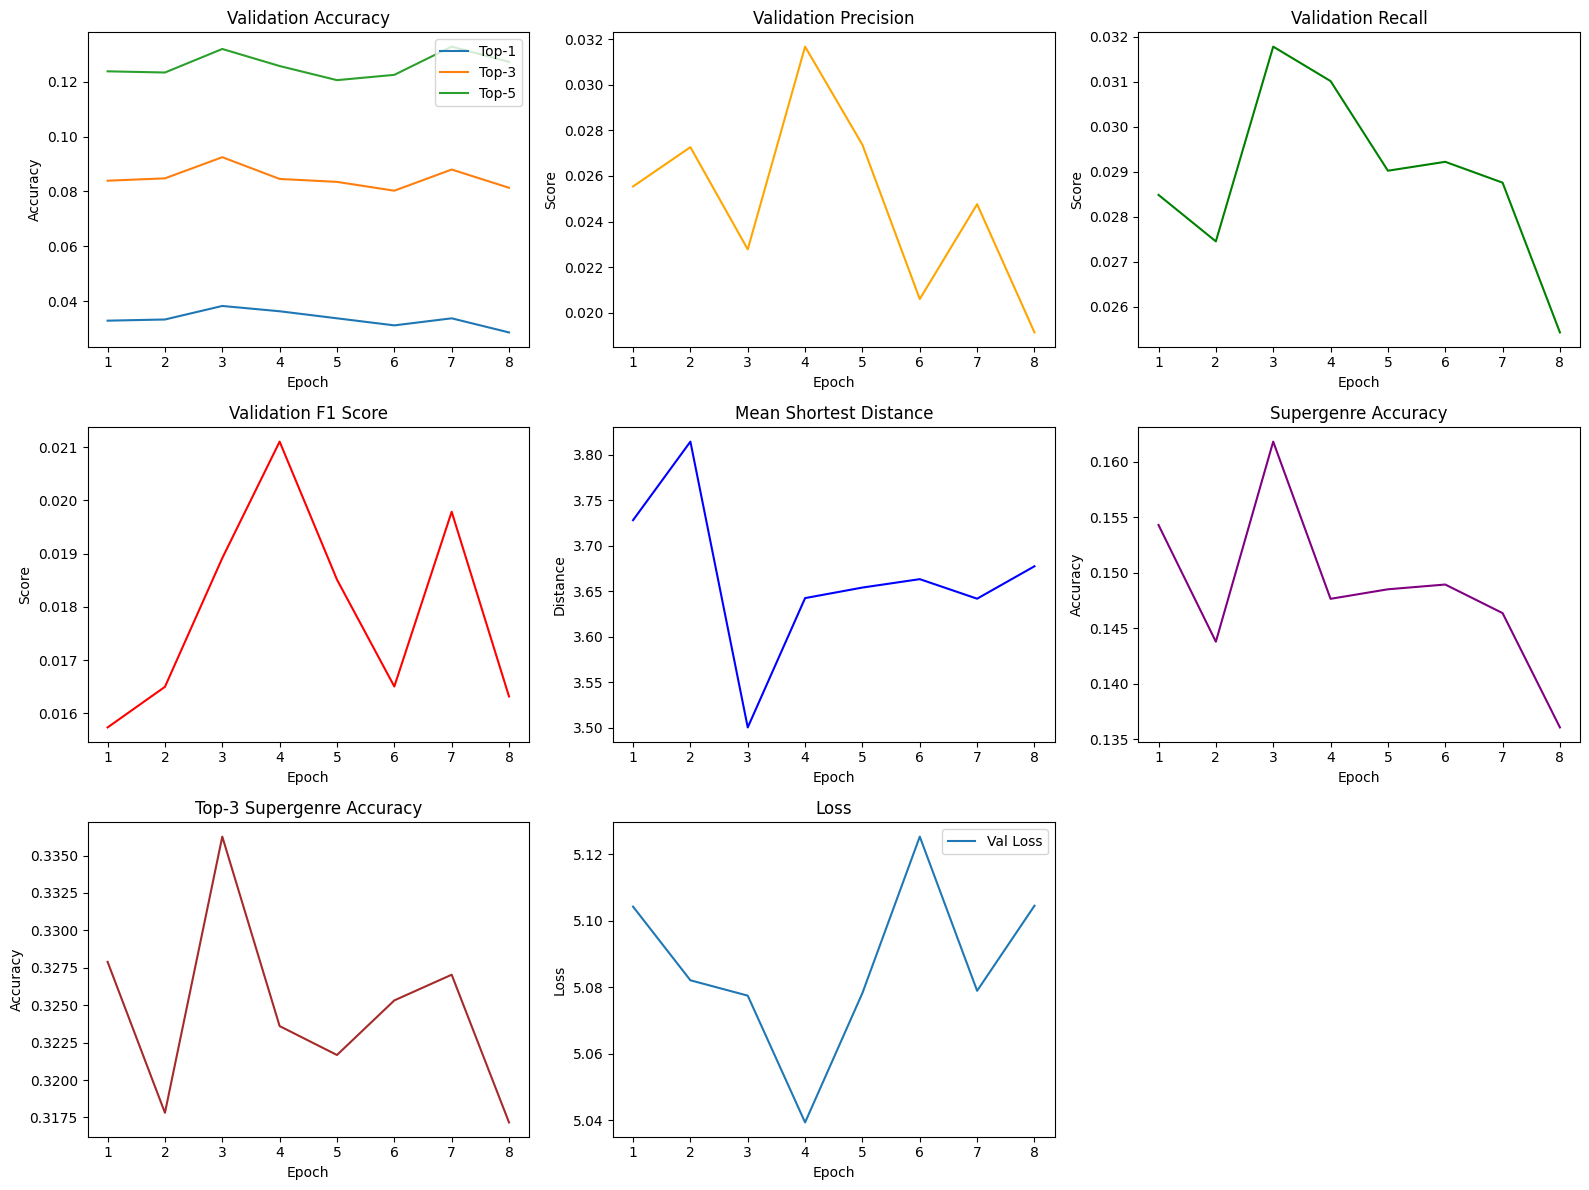

In [22]:
epochs = range(1, len(val_accuracy_list) + 1)

plt.figure(figsize=(16, 12))

# Validation Accuracy
plt.subplot(3, 3, 1)
plt.plot(epochs, val_accuracy_list, label='Top-1')
plt.plot(epochs, top3_acc_list, label='Top-3')
plt.plot(epochs, top5_acc_list, label='Top-5')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision
plt.subplot(3, 3, 2)
plt.plot(epochs, precision_list, label='Precision', color='orange')
plt.title('Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Score')

# Recall
plt.subplot(3, 3, 3)
plt.plot(epochs, recall_list, label='Recall', color='green')
plt.title('Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')

# F1 Score
plt.subplot(3, 3, 4)
plt.plot(epochs, f1_list, label='F1 Score', color='red')
plt.title('Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')

# Mean Shortest Distance
plt.subplot(3, 3, 5)
plt.plot(epochs, mean_dist_list, label='Mean Shortest Distance', color='blue')
plt.title('Mean Shortest Distance')
plt.xlabel('Epoch')
plt.ylabel('Distance')

# Supergenre Accuracy
plt.subplot(3, 3, 6)
plt.plot(epochs, super_acc_list, label='Supergenre Accuracy', color='purple')
plt.title('Supergenre Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Top-3 Supergenre Accuracy
plt.subplot(3, 3, 7)
plt.plot(epochs, super_top3_acc_list, label='Top-3 Supergenre Accuracy', color='brown')
plt.title('Top-3 Supergenre Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Train and Val Loss
plt.subplot(3, 3, 8)
#plt.plot(epochs, train_loss_list, label='Train Loss')
plt.plot(epochs, val_loss_list, label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Train Accuracy
#plt.subplot(3, 3, 9)
#plt.plot(epochs, train_accuracy_list, label='Train Accuracy', color='cyan')
#plt.title('Train Accuracy')
#plt.xlabel('Epoch')
#plt.ylabel('Accuracy')

plt.tight_layout()
plt.savefig("metrics.png")
plt.close()

In [24]:
# Load confusion_matrix.csv and make a heatmap of the confusion matrix
cm_super_df = pd.read_csv("supergenre_confusion_matrix.csv", index_col=0)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_super_df, annot=True, fmt="d", cmap="Blues")
plt.title("Supergenre Confusion Matrix")
plt.ylabel("True Supergenre")
plt.xlabel("Predicted Supergenre")
plt.tight_layout()
plt.savefig("supergenre_confusion_matrix.png")
plt.close()